# Ejemplo del uso de PointNet

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/5-Nubes-Puntos/5-5-Ejemplo-PointNet.ipynb)

Este es un ejemplo de implementación de [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593) usando PyTorch. Se sugiere el uso de una GPU.

Esta implementación se utiliza para el reconocimiento de objetos que se encuentran en formato de nubes de puntos.


In [44]:
import os
import random
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms #, utils

import plotly.graph_objects as go

In [7]:
# Librería adicional para las rutas
!pip install -q path.py

## 1.&nbsp;Carga y exploración de datos

Se utilizará el dataset llamado [ModelNet10](http://3dvision.princeton.edu/projects/2014/3DShapeNets/), el cual contiene 10 categorías, 3991 modelos para entrenamiento y 908 para evaluación (prueba).

In [6]:
!wget -q http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
!unzip -q ModelNet10.zip

In [8]:
from path import Path
path = Path("ModelNet10")

### 1.1. Acceso a los datos

In [11]:
# Verificar las clases que se encuentran en el dataset
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

El dataset consiste de archivos de tipo `.off`, los cuales contienen mallas representadas por *vértices* y caras *triangulares*. La siguiente función lee este tipo de archivos.

### 1.2. Lectura de un objeto del dataset

In [12]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('No es un encabezado OFF válido')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

A modo de ejemplo, se cargará un objeto de la clase "bed" y se mostrará el contenido del enmallado.

In [16]:
with open(path/"bed/train/bed_0001.off", 'r') as f:
    verts, faces = read_off(f)

i, j, k = np.array(faces).T
x, y, z = np.array(verts).T

print("El enmallado tiene {} vértices".format(len(x)))
print("El enmallado tiene {} caras triangulares".format(len(i)))

El enmallado tiene 2095 vértices
El enmallado tiene 1807 caras triangulares


### 1.3. Visualización del enmallado del objeto

La siguiente función se utiliza para mostrar las mallas y las nubes de puntos usando Plotly.

In [17]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]
    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons', showactive=False,
                                          y=1, x=0.8, xanchor='left', yanchor='bottom',
                                          pad=dict(t=45, r=10),
                                          buttons=[dict(label='Play', method='animate',
                                                        args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                         transition=dict(duration=0),
                                                                         fromcurrent=True,
                                                                         mode='immediate' )]
                                                        ) ] ) ] ), frames=frames )
    return fig

In [18]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink',
                            opacity=0.50, i=i,j=j,k=k)]).show()

### 1.4. Visualización de la nube de puntos

La siguiente función se utilizará para visualizar una nube de puntos usando Plotly.

In [19]:
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs, mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                                  line=dict(width=2, color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

## 2.&nbsp;Transformaciones de la nube de puntos



 ### 2.1. Muestreo de puntos

 La siguiente clase se utilizará para muestrear uniformemente puntos de la superficie del objeto.

In [21]:
random.seed = 42
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # Coordenadas del baricentro del triángulo
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))

    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))
        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
        sampled_faces = (random.choices(faces, weights=areas,
                                        cum_weights=None, k=self.output_size))
        sampled_points = np.zeros((self.output_size, 3))
        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        return sampled_points

In [30]:
# Se genera una nube de puntos con 3000 puntos muestreados
pointcloud = PointSampler(3000)((verts, faces))

# Visualización de la nube muestreada
pcshow(*pointcloud.T)

### 2.2. Normalización

Se normalizará el tamaño del objeto dentro de una esfera unitaria (escala de 0 a 1) para que exista uniformidad independientemente del tamaño real del objeto.

In [31]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))
        return  norm_pointcloud

In [32]:
# Normalización de la nube de puntos muestreada
norm_pointcloud = Normalize()(pointcloud)

# Visualización de la normalización
pcshow(*norm_pointcloud.T)

### 2.3. Incremento de datos

En este caso, para incrementar las nubes de puntos, se añadirá rotaciones a toda la nube de puntos (alrededor del eje Z), así como ruido gaussiano a cada punto

In [33]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        theta = 2.0*np.pi*random.random()
        rot_matrix = np.array([[ np.cos(theta), -np.sin(theta), 0],
                               [ np.sin(theta),  np.cos(theta), 0],
                               [             0,              0, 1]])
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return rot_pointcloud

class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        noise = np.random.normal(0, 0.02, (pointcloud.shape))
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [35]:
# Nube de puntos rotada en z
rot_pointcloud = RandRotation_z()(norm_pointcloud)

# Nube de puntos con ruido gaussiano añadido
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

# Visualización de la rotación y ruido
pcshow(*noisy_rot_pointcloud.T)

### 2.4. Conversión a Tensor de PyTorch

In [36]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        return torch.from_numpy(pointcloud)

In [37]:
ToTensor()(noisy_rot_pointcloud)

tensor([[-0.8608,  0.0193,  0.0301],
        [-0.1878, -0.1613, -0.1164],
        [-0.6630,  0.3109, -0.0303],
        ...,
        [ 0.1089,  0.3492,  0.1684],
        [ 0.1982,  0.3258,  0.1269],
        [ 0.2203,  0.1472,  0.0350]], dtype=torch.float64)

La siguiente función realiza por defecto el muestreo de 1024 puntos por objeto, luego normaliza la nube de puntos y finalmente convierte el resultado a un tensor de PyTorch.

In [42]:
def default_transforms():
    return transforms.Compose([PointSampler(1024), Normalize(), ToTensor() ])

## 3.&nbsp;Creación de un Dataset para PyTorch

Se creará un [dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) de Pytorch.

In [45]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud,
                'category': self.classes[category]}

Para el entrenamiento se utilizará 1024 puntos para cada nube de puntos. La composición de transformaciones es: muestreo de 1024 puntos, normalización, rotación aleatoria alrededor del eje Z, adición de ruido gaussiano y conversión a tensor.



In [46]:
train_transforms = transforms.Compose([PointSampler(1024), Normalize(),
                                       RandRotation_z(), RandomNoise(),
                                       ToTensor()
                                       ])

Creación del dataset para el conjunto de entrenamiento y validación, utilizando las transformaciones anteriores para cada nube de puntos.

In [47]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

Mostrar las clases (categorías) existentes en el conjunto de entrenamiento.

In [49]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()}
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [50]:
print('Tamaño del conjunto de entrenamiento:', len(train_ds))
print('Tamaño del conjunto de validación:', len(valid_ds))
print('Número de clases:', len(train_ds.classes))

print('\nTamaño de una muestra de nube de puntos:', train_ds[0]['pointcloud'].size())
print('Clase de la muestra utilizada:', inv_classes[train_ds[0]['category']])

Tamaño del conjunto de entrenamiento: 3991
Tamaño del conjunto de validación: 908
Número de clases: 10

Tamaño de una muestra de nube de puntos: torch.Size([1024, 3])
Clase de la muestra utilizada: bathtub


In [51]:
# Generación de dataloaders de PyTorch para entrenamiento y validación
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

## 4.&nbsp;Modelo de la red neuronal

Se define la arquitectura de la red neuronal utilizada en PointNet

In [52]:
import torch.nn as nn
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)
      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)

   def forward(self, input):
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      # Inicializar como identidad
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix

class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)
        xb = F.relu(self.bn1(self.conv1(xb)))
        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

Definición de la función de costo

In [53]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

## 5.&nbsp;Entrenamiento de la red neuronal

In [55]:
# Verificar si se está utilizando cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [57]:
# Creación de la red neuronal
pointnet = PointNet()

# Carga de la red neuronal en el dispositivo (GPU, si está disponible)
pointnet.to(device);

In [58]:
# Definición del optimizador
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [59]:
# Función para realizar el entrenamiento
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    for epoch in range(epochs):
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))
            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()
            # Mostrar estadísticas
            running_loss += loss.item()
            if i % 10 == 9:    # Mostrar cada 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                          (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0
        pointnet.eval()
        correct = total = 0

        # Validación
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # Almacenar el modelo
        if save:
            torch.save(pointnet.state_dict(), "save_"+str(epoch)+".pth")

In [ ]:
train(pointnet, train_loader, valid_loader, save=True)

## 6.&nbsp;Evaluación (Prueba)

In [61]:
# Creación de la arquitectura de PointNet
pointnet = PointNet()

Luego de crear la arquitectura se debe cargar el modelo (los pesos) pre-entrenado. En este caso, se descargará un modelo que ya fue entrenado, con el fin de evaluarlo.

In [62]:
!wget -q https://raw.githubusercontent.com/oscar-ramos/robotica-autonoma-python/main/5-Nubes-Puntos/modelo1.pth

In [ ]:
# Carga de un modelo pre-entrenado
pointnet.load_state_dict(torch.load('/content/modelo1.pth'))
pointnet.eval();

In [67]:
# Etiquetas predichas
y_pred = []
# Etiquetas reales
y_real = []

with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        y_pred += list(preds.numpy())
        y_real += list(labels.numpy())

Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]


Para evaluar se utilizará una matriz de confusión. En este caso se utilizará la función `confusion_matrix` de scikit-learn.

In [68]:
from sklearn.metrics import confusion_matrix

# Comparación de las etiquetas reales con las predichas
cm = confusion_matrix(y_real, y_pred)
cm

array([[ 41,   9,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,  96,   2,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
       [  1,   2,   2,  31,   6,   0,  18,   5,  20,   1],
       [  0,   0,   0,   0,  40,   0,  45,   0,   1,   0],
       [  0,   0,   1,   0,  24,  72,   2,   1,   0,   0],
       [  0,   0,   1,   0,   6,   0,  78,   0,   1,   0],
       [  0,   0,   1,   0,   1,   0,   1,  97,   0,   0],
       [  0,   0,   0,   6,   0,   0,   1,   0,  93,   0],
       [  1,   0,  13,   0,   1,   0,   2,   1,   0,  82]])

In [69]:
import itertools
import matplotlib.pyplot as plt

# Función para graficar una matriz de confusión
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalización')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')

Matriz de confusión normalizada


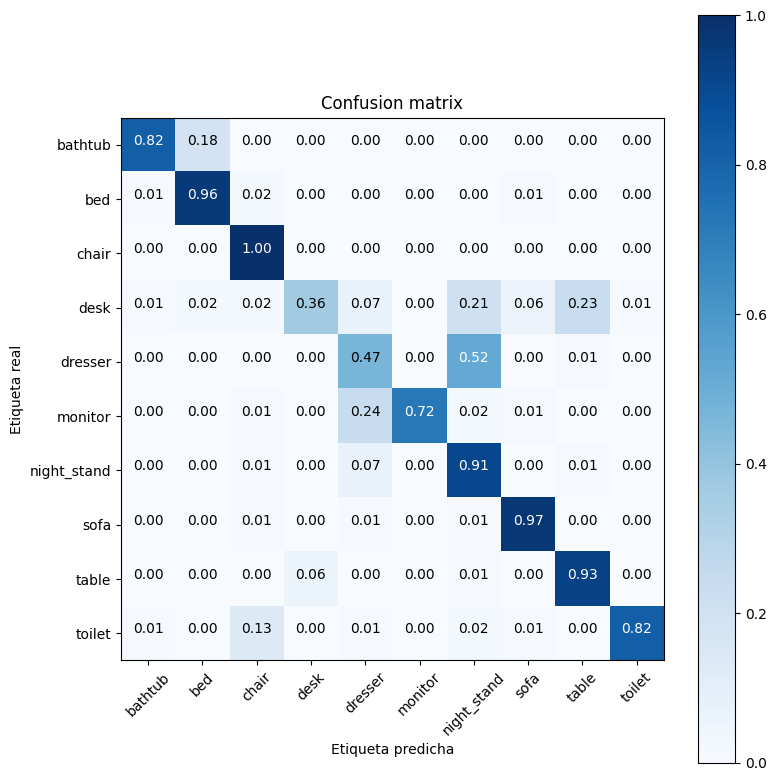

In [70]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Matriz de confusión sin normalización


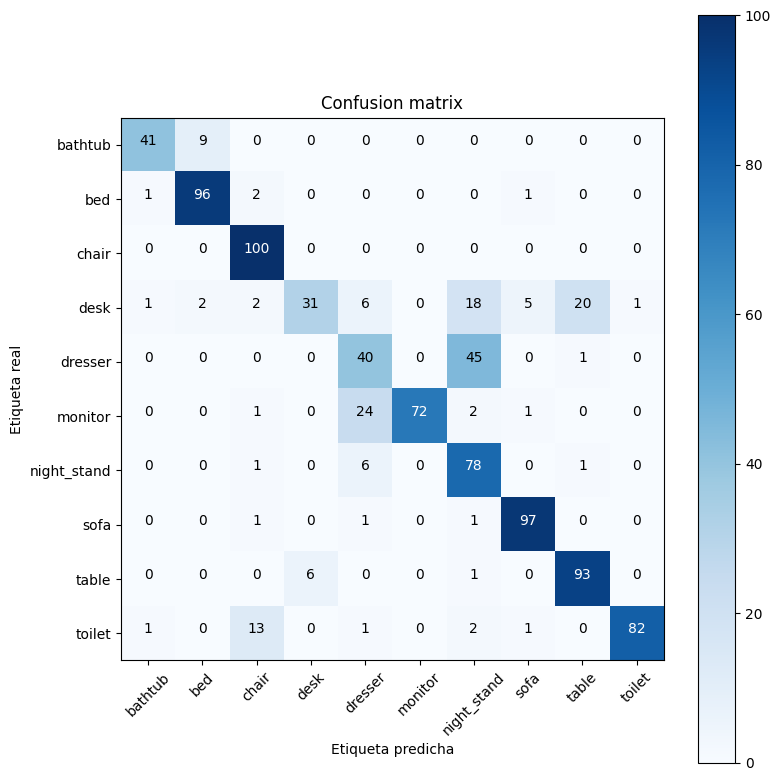

In [71]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)